In [1]:
!git clone https://github.com/ultralytics/yolov5.git
!pip install -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16941, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 16941 (delta 68), reused 91 (delta 50), pack-reused 16805 (from 1)
Receiving objects: 100% (16941/16941), 15.70 MiB | 24.51 MiB/s, done.
Resolving deltas: 100% (11601/11601), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 646.9 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.0/872.0 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.5.0 requires shapely>=2, but you have shapely 1.

In [12]:
import pandas as pd
import cv2
import os
import shutil
import yaml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np
import torch
from pathlib import Path
from yolov5.models.yolo import Model
from PIL import Image
import sys
from IPython.display import display

In [3]:
input_data_path = '/kaggle/input/car-object-detection'
output_path = os.getcwd()

df = pd.read_csv(os.path.join(input_data_path, 'data/train_solution_bounding_boxes (1).csv'))

def get_width_and_height(img_path):
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    return height, width

def convert_to_yolo_bbox(bbox, w, h):
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return x_center, y_center, width, height

def prepare_data(df):
    data = {'image': [], 'bbox_x': [], 'bbox_y': [], 'bbox_width': [], 'bbox_height': [], 'class': []}
    images_width = {}
    images_height = {}
    for _, row in df.iterrows():
        img_path = os.path.join(input_data_path, 'data/training_images', row['image'])
        height, width = get_width_and_height(img_path)
        x_center, y_center, width_bbox, height_bbox = convert_to_yolo_bbox(row[1:], width, height) 
        data['image'].append(row['image'])
        data['bbox_x'].append(x_center)
        data['bbox_y'].append(y_center)
        data['bbox_width'].append(width_bbox)
        data['bbox_height'].append(height_bbox)
        data['class'].append(0)  # assuming 'car' is the only class
        images_width[row['image']] = width
        images_height[row['image']] = height
    df_yolo = pd.DataFrame(data)
    df_yolo['bboxes'] = df_yolo[['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].apply(list, axis=1)
    df_yolo = df_yolo.drop(columns=['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height'])
    df_yolo['height'] = df_yolo['image'].map(images_height)
    df_yolo['width'] = df_yolo['image'].map(images_width)
    df_yolo = df_yolo.groupby('image').agg(list).reset_index()
    return df_yolo

df_yolo = prepare_data(df)

/tmp/ipykernel_36/1921017890.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_center = ((bbox[2] + bbox[0]) / 2) / w
/tmp/ipykernel_36/1921017890.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_center = ((bbox[3] + bbox[1]) / 2) / h
/tmp/ipykernel_36/1921017890.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  width = (bbox[2] - bbox[0]) / w
/tmp/ipykernel_36/1921017890.py:15: FutureWarning: Series.__getitem__ treati

In [4]:
train_df, val_df = train_test_split(df_yolo, test_size=0.2)
train_images_names = train_df['image'].to_list()
val_images_names = val_df['image'].to_list()

In [5]:
data_path = os.path.join(output_path, 'yolov5', 'car_detect')
train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')

train_images_path = os.path.join(train_path, 'images')
train_labels_path = os.path.join(train_path, 'labels')
val_images_path = os.path.join(val_path, 'images')
val_labels_path = os.path.join(val_path, 'labels')

test_img_path_start = os.path.join(input_data_path, 'data/testing_images')
test_img_path = os.path.join(output_path, 'test_images')
test_img_names = os.listdir(test_img_path_start)

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

ensure_dir(train_path)
ensure_dir(val_path)
ensure_dir(test_img_path)
ensure_dir(train_images_path)
ensure_dir(train_labels_path)
ensure_dir(val_images_path)
ensure_dir(val_labels_path)

In [6]:
def copy_images(img_names, src_dir, dest_dir):
    for img_name in img_names:
        src = os.path.join(src_dir, img_name)
        dest = os.path.join(dest_dir, img_name)
        if os.path.isfile(src):
            shutil.copy(src, dest)
        else:
            print(f"Warning: Image {src} not found.")

def make_labels_files(df, label_path):
    for _, row in df.iterrows():
        with open(f"{os.path.join(label_path, row['image'][:-3])}txt", 'w') as file:
            text = ''
            for bbox in row['bboxes']:
                text += f'{row["class"][0]} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n'
            file.write(text)

make_labels_files(train_df, train_labels_path)
make_labels_files(val_df, val_labels_path)

copy_images(train_images_names, os.path.join(input_data_path, 'data/training_images'), train_images_path)
copy_images(val_images_names, os.path.join(input_data_path, 'data/training_images'), val_images_path)
copy_images(test_img_names, test_img_path_start, test_img_path)

In [7]:
data_path = '/kaggle/working/yolov5/car_detect'
data_yaml_path = os.path.join(data_path, 'data.yaml')

data = {
    'train': os.path.join(data_path, 'train', 'images'),
    'val': os.path.join(data_path, 'val', 'images'),
    'test': os.path.join(data_path, 'test_images'),
    'nc': 1,
    'names': ['car']
}

with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f)

print(f"Created data.yaml at {data_yaml_path}")

Created data.yaml at /kaggle/working/yolov5/car_detect/data.yaml


In [8]:
!ls /kaggle/working/yolov5/car_detect/train

images	labels


In [9]:
!ls /kaggle/working/yolov5/car_detect

data.yaml  train  val


In [10]:
!export WANDB_MODE=disabled && cd yolov5 && python train.py --img-size 640 --batch-size 16 --epochs 50 --data {data_path}/data.yaml --cfg yolov5s.yaml --weights '' --name yolov5_car_detection --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
train: weights=, cfg=yolov5s.yaml, data=/kaggle/working/yolov5/car_detect/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5_car_detection, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-363-gf44db010 Python-3.10.14 torch

In [11]:
!cd yolov5 && python detect.py --weights /kaggle/working/yolov5/runs/train/yolov5_car_detection/weights/best.pt --img-size 640 --conf-thres 0.4 --source /kaggle/working/test_images --save-txt --save-crop

detect: weights=['/kaggle/working/yolov5/runs/train/yolov5_car_detection/weights/best.pt'], source=/kaggle/working/test_images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-363-gf44db010 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/175 /kaggle/working/test_images/vid_5_25100.jpg: 384x640 (no detections), 30.9ms
image 2/175 /kaggle/working/test_images/vid_5_25120.jpg: 384x640 (no detections), 7.5ms
image 3/175 /kaggle/working/test_images/vid_5_25140.jpg: 384x640 (no detections), 7.5ms
image 4/

In [13]:
def display_predictions(image_path, label_dir):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to open image file {image_path}.")
        return
    img_height, img_width = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_rgb)
    label_file = os.path.join(label_dir, os.path.splitext(os.path.basename(image_path))[0] + '.txt')
    if not os.path.isfile(label_file):
        print(f"Warning: No label file found for {image_path}.")
        plt.axis('off')
        plt.close(fig)
        return
    with open(label_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 5:
                print(f"Warning: Incorrect format in label file {label_file}.")
                continue
            class_id, x_center, y_center, width, height = map(float, parts)
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
    ax.set_title(os.path.basename(image_path))
    ax.axis('off')  # Hide the axis
    plt.close(fig)  # Close the figure to avoid memory issues
    display(fig)  # Display the figure

In [ ]:
test_img_path = '/kaggle/working/test_images'
label_path = '//kaggle/working/yolov5/runs/detect/exp/labels'
test_images = [f for f in os.listdir(test_img_path) if f.lower().endswith(('.jpg', '.png'))]
random_images = random.sample(test_images, min(15, len(test_images)))

for file_name in random_images:
    image_path = os.path.join(test_img_path, file_name)
    display_predictions(image_path, label_path)

In [15]:
!python yolov5/export.py --weights /kaggle/working/yolov5/runs/train/yolov5_car_detection/weights/best.pt --img-size 640 --batch-size 1 --device cpu --include onnx

export: data=yolov5/data/coco128.yaml, weights=['/kaggle/working/yolov5/runs/train/yolov5_car_detection/weights/best.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-363-gf44db010 Python-3.10.14 torch-2.4.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /kaggle/working/yolov5/runs/train/yolov5_car_detection/weights/best.pt with output shape (1, 25200, 6) (13.7 MB)

ONNX: starting export with onnx 1.16.2...
ONNX: export success ✅ 1.0s, saved as /kaggle/working/yolov5/runs/train/yolov5_car_detection/weights/best.onnx (27.2 MB)

Export complete (1.9s)
Results saved to /kaggle/working/yolov5/runs/train/yolov5_car_detection/weig

In [16]:
sys.path.append('/kaggle/working/yolov5')
model_path = '/kaggle/working/yolov5/runs/train/yolov5_car_detection/weights/best.pt'
model = torch.hub.load('/kaggle/working/yolov5', 'custom', path=model_path, source='local')
model.eval()

YOLOv5 🚀 v7.0-363-gf44db010 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [43]:
test_images_dir = '/kaggle/input/car-detection-testing'

def predict_images(model, image_dir):
    image_paths = list(Path(image_dir).glob('*.*'))
    results = []
    for image_path in image_paths:
        img = cv2.imread(str(image_path))
        if img is None:
            print(f"Skipping file (not an image or corrupted): {image_path}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results.append((image_path, model(img_rgb)))
    return results

results = predict_images(model, test_images_dir)

for img_path, result in results:
    pred_df = result.pandas().xyxy[0] 
    print(f"Processing: {img_path.name}")
    print(f"Predictions for {img_path.name}:")
    print(pred_df)
    print("\n")

/kaggle/working/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/kaggle/working/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/kaggle/working/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Processing: 6.jpg
Predictions for 6.jpg:
         xmin        ymin        xmax        ymax  confidence  class name
0  156.780090  124.434135  236.441528  151.883804    0.720914      0  car
1  195.993683  170.654755  296.417267  253.289459    0.447354      0  car


Processing: 5.jpg
Predictions for 5.jpg:
        xmin        ymin        xmax        ymax  confidence  class name
0  98.791412  144.274689  157.702225  176.795151    0.586478      0  car


Processing: 1.JPG
Predictions for 1.JPG:
          xmin        ymin         xmax         ymax  confidence  class name
0   648.994019  985.425598   950.533813  1294.453369    0.743054      0  car
1  1650.010376  603.585815  1857.848999   807.754089    0.267704      0  car


Processing: 3.jpeg
Predictions for 3.jpeg:
         xmin         ymin         xmax         ymax  confidence  class name
0  925.523254  1413.134644  1370.387939  1649.594604    0.860124      0  car


Processing: 4.jpg
Predictions for 4.jpg:
         xmin        ymin       

/kaggle/working/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/kaggle/working/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/kaggle/working/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [45]:
def draw_boxes(img, pred, image_name, max_size=(1024, 768)):
    height, width = img.shape[:2]
    scale = min(max_size[0] / width, max_size[1] / height)
    new_width = int(width * scale)
    new_height = int(height * scale)
    resized_img = cv2.resize(img, (new_width, new_height))
    img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_rgb)
    pred_df = pred.pandas().xyxy[0]
    if not pred_df.empty:
        for _, row in pred_df.iterrows():
            x_min = int(row["xmin"] * scale)
            y_min = int(row["ymin"] * scale)
            x_max = int(row["xmax"] * scale)
            y_max = int(row["ymax"] * scale)
            label = f'{row["name"]} {row["confidence"]:.2f}'
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            plt.text(x_min, y_min - 10, label, color='r', fontsize=10, weight='bold')
    ax.set_title(f'Predictions for {image_name}')
    ax.axis('off')
    plt.close(fig) 
    display(fig) 

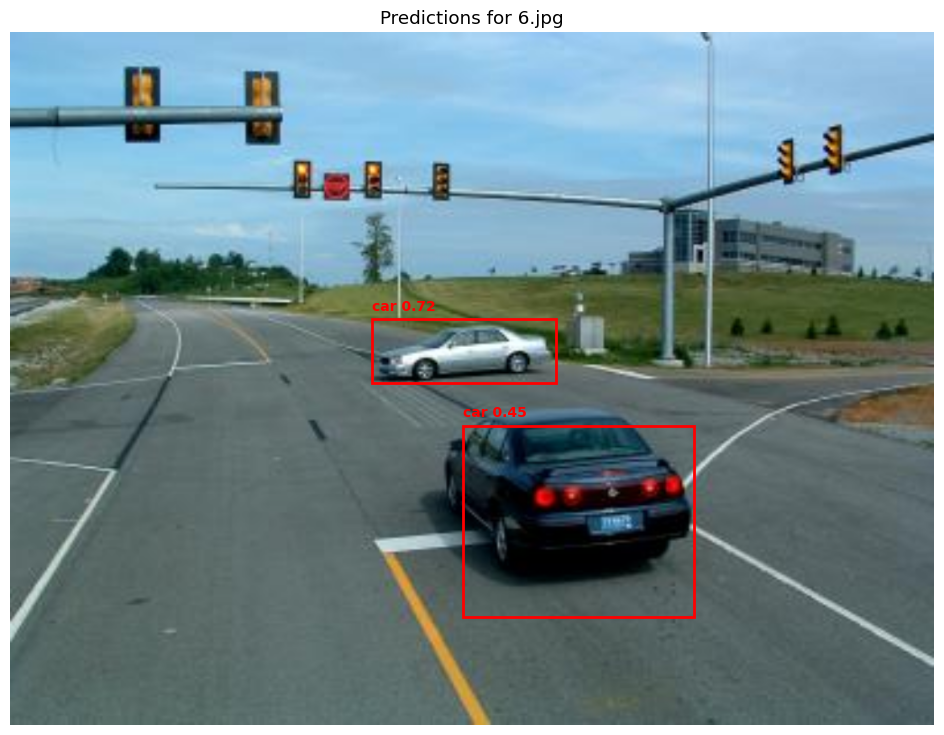

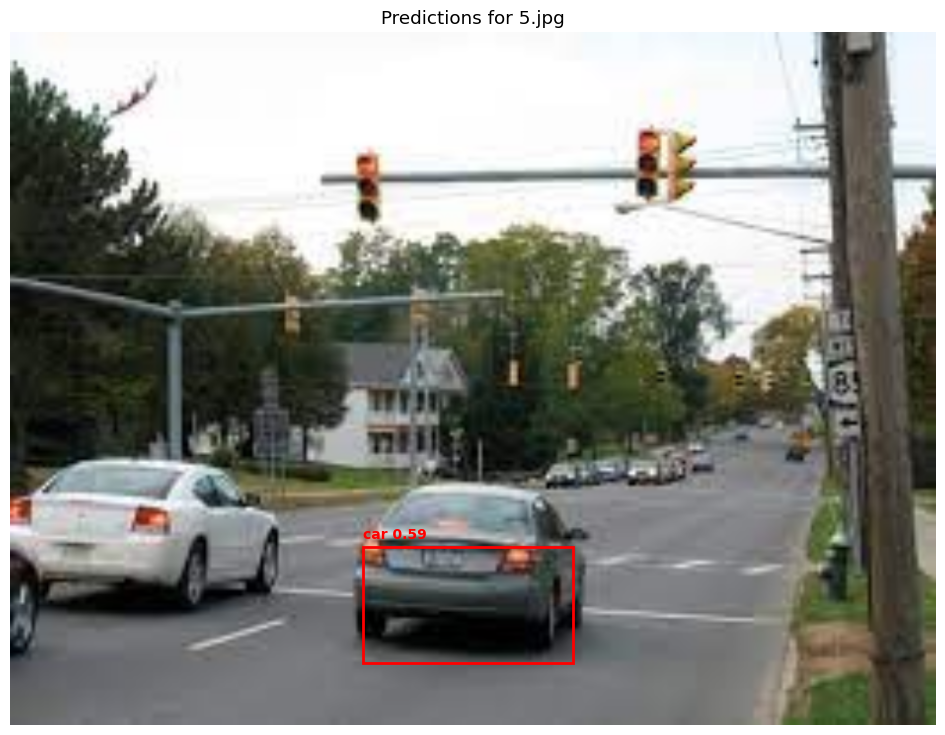

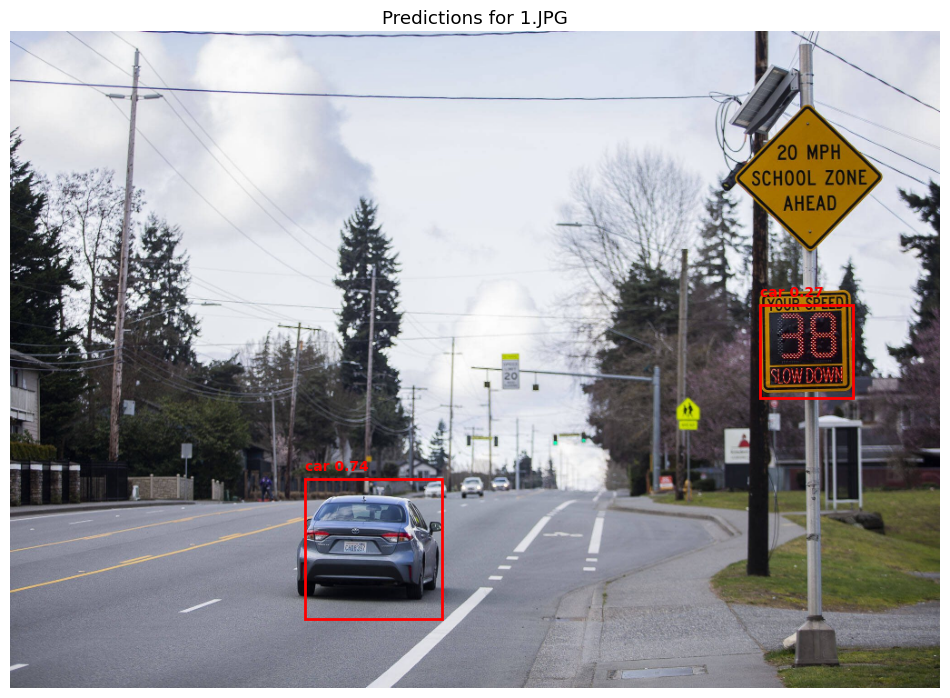

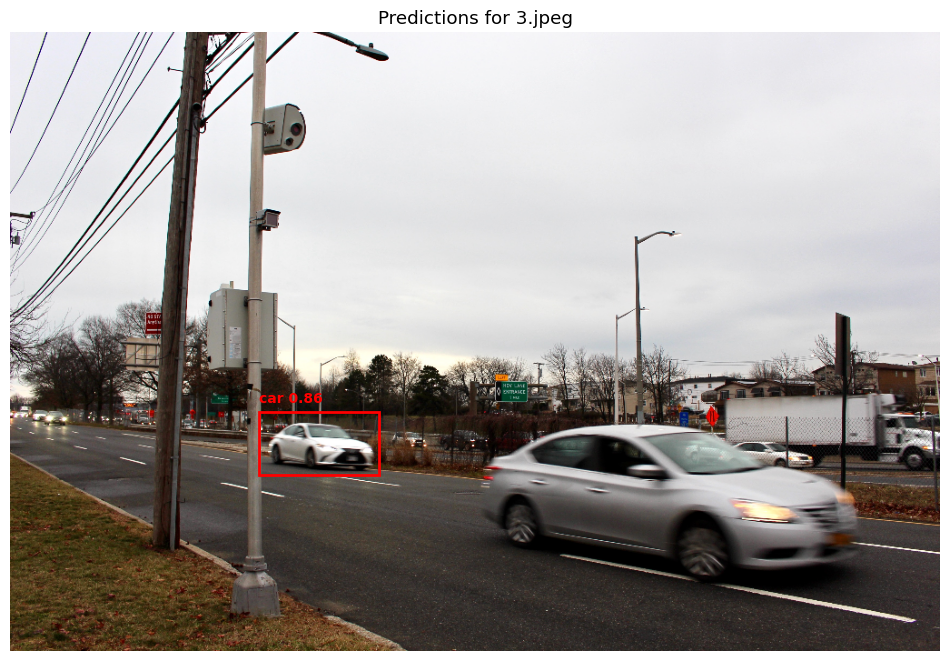

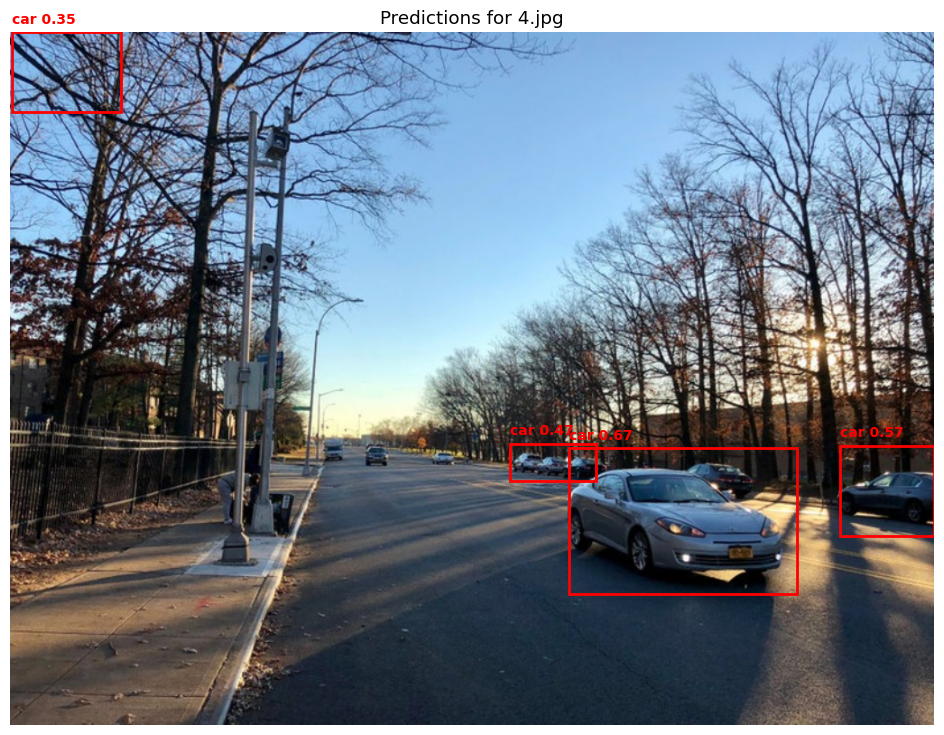

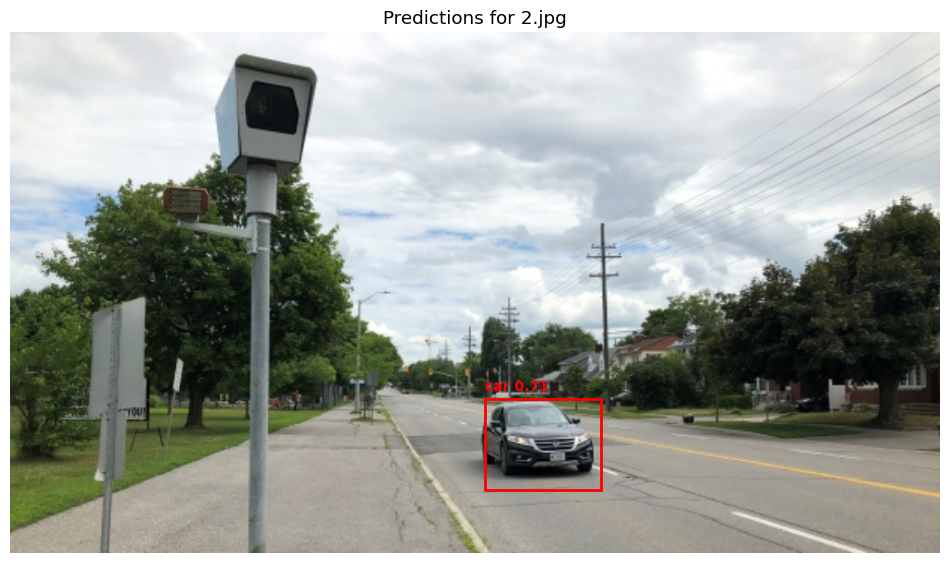

In [46]:
for img_path, result in results:
    img = cv2.imread(str(img_path))
    if img is not None:
        image_name = img_path.name
        draw_boxes(img, result, image_name)